# SpaMod_2 is a good rewriting of the function!!! (except nev which is slightly different)

In [95]:
%load_ext oct2py.ipython
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import math
#import matplotlib.pyplot as plt

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [96]:
from oct2py import octave
_ = octave.addpath('/home/urban_communities/scripts') # KERDES HOL VAN?
_ = octave.addpath('/home/ubuntu/GenLouvain/')
_ = octave.addpath('/home/ubuntu/GenLouvain/private/')
from time import time
from copy import deepcopy

In [97]:
%matplotlib inline

* Ctrl + shift + - tori el a cellat
* Shift + M = merge
* az ocatve-ban a ' a transzponalas
* az octave szigoruan megkulonbozteti a sor- es oszlopvektorokat
* az octave vektor/matrix objektumai jobban hasonlitanak a np.matrix-ra mint az array-re
* az octave-ban a ./ .* stb. mindig az elemenkenti muveleteket jelentik, mintha np.array-ekkel dolgoznal
* az octave 1-tol indexel, a Python 0-tol

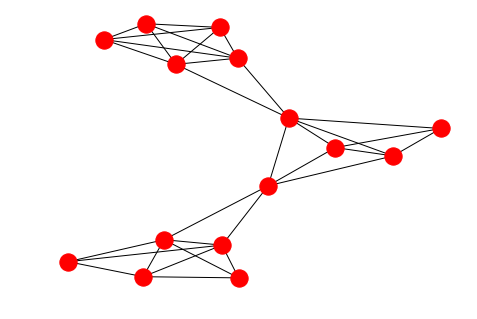

In [98]:
# Eszter graph
# a good modular input matrix
p = np.ones((3,3))*0.05 + np.eye(3)*(1-3*0.05)
G = nx.stochastic_block_model([5]*3,p) # 20 helyett 5
nx.draw(G)

In [99]:
# adjacency matrix
A = nx.adjacency_matrix(G)
# distance matrix
D = np.random.rand(len(G.nodes()),len(G.nodes()))
# importance
N = np.matrix([v for (k,v) in G.degree]).T # KERDES nem lenne jobb meghagyni vektornak, ha ugyis 1 dimenzios??
# binsize
b = 0.05

In [100]:
A.todense()

matrix([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [101]:
# TRY- modified code without loops to test code line by line

In [188]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N,nGN,nSpa,deg,szam,nev

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')
function [ModularitySpa,ModularityGN,DeterrenceFct,nullmodelGN,nullmodelSpa,degree,szamlalo,nevezo]=ModularitySpaGN(Flow,Dist,N,binsize);
    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)
    
    %disp("Beginning of modularity function...");

    number=size(Flow,1); %number of nodes in the system

    nbox=20; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);

    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix
    
    %disp("Preparation done.")
    
    %disp("Deterrence function...")

    %We first calculate the correlations as a function of distance

    for i=1:number
        %disp(i)
        for ii=1:number

        % convert distances in binsize's units
        dist=ceil(Dist(i,ii)/binsize); %%%%%%% KERDES: NEM ERTEK VELE EGYET, KITOROLheTEM A +1-ET??
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii);
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end
    %disp("Done.")

    %disp("Normalization...")
    % normalisation of the deterrence function
    for i=1:nbox
        %disp(i)
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end
    
    %disp("Done.")
    
    %disp("Null modell...")

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end
    
    %disp("Done.")

    %disp("Modularity calc...")
    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));
    
    szamlalo = nullN.*nullmodelSpa*sum(sum(Flow))
    nevezo = sum(sum(nullN.*nullmodelSpa))

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
    %disp("Done.")
endfunction


[Ms,Mg,Dfn,nGN,nSpa,deg,szam,nev] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Ms);

szamlalo =

 Columns 1 through 6:

    93.51598   141.24138   120.47059    88.19139    76.80000    83.93443

   119.06977   211.86207    68.87892   132.28708    26.36910   220.47847

    96.00000   123.20856   183.73206    34.59459   146.98565    62.13592

    56.88889   105.93103    34.43946     9.88841    59.53488    34.43946

    79.37984    98.56684   116.89498    61.93548    20.48000    21.97425

   117.25191   154.83871   131.28205    87.67123    25.60000   120.00000

   117.58852   113.77778    99.22481    49.28342    93.51598   116.89498

    83.93443   175.34247     0.00000    77.41935    49.70874    57.65766

    65.71123   159.17098    29.59538    15.36000    94.16092   103.22581

    76.80000   176.38278    83.93443    13.18455    17.57940    99.22481

     0.00000   108.42353    22.19653    52.60274    57.60000    16.48069

   132.64249    68.87892   165.80311    72.00000    49.70874    32.00000

    79.37984   119.06977    29.59538     0.00000   106.11399   103.22581

    25.60000    69.18919   165.80311    61.60428   105.02564   104.91803

    70.62069    41.32735    90.35294    13.31792    61.93548    87.93893

 Columns 7 through 12:

     0.00000    96.00000    93.51598    36.73543    50.36066    29.59538

   159.17098   123.20856    98.56684   115.20000    89.30233   142.22222

    46.12613    57.65766    25.60000    49.70874    62.95082   131.28205

    57.60000    16.48069    59.53488    70.13699    20.75676    37.28155

    20.48000     0.00000     0.00000    75.85185    17.75723   105.02564

    99.22481   118.51852    96.00000    96.00000    16.48069   129.03226

     0.00000   117.70115   106.11399   106.11399    72.28235    29.59538

    29.59538     0.00000    96.00000   120.47059    77.41935    57.65766

    36.73543    83.93443    20.48000    36.90090    27.55157    96.00000

   117.58852    94.81481    93.80153    65.71123    29.82524    83.93443

    13.18455    88.27586     0.00000    59.53488    52.96552    62.95082

   103.22581    27.46781     0.00000    83.93443    72.00000    36.99422

    36.90090    45.91928   117.58852    93.51598    63.01538   117.25191

    82.13904   124.03101    96.00000   146.98565    78.76923    62.13592

    57.60000    74.41860    17.75723    15.36000    43.20000    87.93893

 Columns 13 through 15:

    84.02051    49.70874    59.53488

    59.65049   157.53846    19.77682

     0.00000    62.13592    34.43946

    57.60000    77.41935    52.96552

    36.73543    94.81481    57.60000

   105.02564   129.03226    71.11111

    17.57940    21.97425    15.36000

   117.25191   146.56489    99.48187

    17.57940    45.91928    50.36066

    20.48000     0.00000    59.53488

    63.01538    77.41935    46.45161

    83.93443   104.91803    88.27586

    36.90090   116.89498    88.19139

   116.89498    57.65766    77.41935

    79.58549    19.20000    52.60274

nevezo =  128

Ide jon alulra a Python code

In [145]:
def SpaMod(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");
    
    number=A.shape[0] # number of nodes
    nbox = 20 ## MODIFIED number of bins JAVITASHOZ PROBA!!!!!!
    
    # intialisation of different vectors and matrices
    DeterrenceFct=np.zeros((nbox,1));
    normaDeterrence=np.zeros((nbox,1));
    matrixdistance=np.zeros((number,number));
    nullmodelGN=np.zeros((number,number));
    nullmodelSpa=np.zeros((number,number));
    
    A = A + A.T # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    
    degree = A.sum(axis=0) 
    # np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    # JAVITAS degree matrix formaban hagyva
    
    
    nullN = N * N.T # matrix of the importance of nodes
    
    # matrix = np.divide(A.T,nullN) ## KERDESES, HOGY JO-e
    matrix = A/nullN # normalized adjacency matrix
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    print('Preparation done.')
    
    print('Deterrence function...')

    for i in range(number):
        for ii in range(number):
            
            # convert distances in binsize's units
            dist = math.floor(D[i,ii]/b);
            matrixdistance[i,ii]=dist;

            # weighted average for the deterrence function
            num = matrix[i,ii];
            DeterrenceFct[dist,0]=DeterrenceFct[dist,0]+num*N[i,0]*N[ii,0];
            normaDeterrence[dist,0]=normaDeterrence[dist,0]+N[i,0]*N[ii,0];
            # ALTERNATIVELY
            # ceiler = lambda x: math.ceil(x)
            # vceil = np.vectorize(ceiler)
            # matrixdistance = vceil(D/b)
            # DeterrenceFct = DeterrenceFct + np.multiply(np.multiply(N,N.T),matrix)
            # normaDeterrence = normaDeterrence + np.multiply(N,N.T)
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
   
    print('Normalization...')
    # normalisation of the deterrence function - NINCS ELLENŐRIZVE EZ A CIKLUS
    for i in range(nbox):
        if(normaDeterrence[i,0]!=0):
            DeterrenceFct[i,0]=DeterrenceFct[i,0]/normaDeterrence[i,0];

    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc
    
    print("Null modell...")
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    for i in range(number):
        for ii in range(number):
            nullmodelSpa[i,ii]=DeterrenceFct[matrixdistance[i,ii].astype(int),0];
    print("Done.")
    
    print("Modularity calc...")
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(nullN, nullmodelSpa*A.sum()/np.multiply(nullN,nullmodelSpa).sum());
    
    # the modularity matrix for the GN null-model
    nullmodelGN = degree.T*degree/degree.sum(); # Newman-Girvan null-model
    ModularityGN=A-nullmodelGN;
    print("Done.")
    return ModularitySpa,ModularityGN,DeterrenceFct,nullmodelSpa, nullmodelGN, normaDeterrence, matrixdistance

In [184]:
# ALTERNATIVE - WORKS EXCEPT nev =/= nev from octave --> Ms is a bit different

def SpaMod_2(A,D,N,b): # flow - adjacency matrix
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    b : float
        size of the bins in the estimation of the deterrence function
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");   
    # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    A = A + A.T ### KERDES KELL-e?? TODO ATGONDOLNI? ILLETVE LE KELL-e osztani 2-vel   / 2     
        
    # deterrence function
    det, detbins = np.histogram(
        D.flatten(),
        range = (0, np.ceil(D.max()/b)*b), # JAVITAS
        weights = np.array(A.todense()).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    normadet, _ = np.histogram(
        D.flatten(), 
        range = (0, np.ceil(D.max()/b)*b),
        weights = np.array(N*N.T).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    det = det / normadet
    det[np.isnan(det)] = 0
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    tic = toc
    
    print("Null modell...")
    
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    nullmodelSpa = det[np.digitize(D,detbins,right=True)-1]
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    tic = toc
    
    print("Modularity calc...")
    
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(N*N.T, nullmodelSpa*A.sum())/(np.multiply(N*N.T,nullmodelSpa).sum())
    szamlalo = np.multiply(N*N.T, nullmodelSpa*A.sum())
    nevezo = np.multiply(N*N.T,nullmodelSpa).sum()
    
    # the modularity matrix for the GN null-model
    degree = degree = A.sum(axis=0) # JAVITVA np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullmodelGN = degree.T*degree/degree.sum() # Newman-Girvan null-model
    ModularityGN = A - nullmodelGN
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    return ModularitySpa, ModularityGN,det,nullmodelSpa, nullmodelGN,normadet, detbins, szamlalo, nevezo

In [185]:
A.sum()

64

In [186]:
Ms_1, Mgn_1,Dfn_1,nSpa_1, nGN_1, nDfn_1, matrixdist_1  = SpaMod(A,D,N,b)
S_ms_1,Q_ms_1,n_it_ms_1 = octave.iterated_genlouvain(Ms_1, nout=3)

Beginning of modularity function...
Done. 0.00
Preparation done.
Deterrence function...
Done. 0.00
Normalization...
Done. 0.00
Null modell...
Done.
Modularity calc...
Done.


In [187]:
Ms_2, Mgn_2,Dfn_2,nSpa_2, nGN_2, nDfn_2, detbins_2, szam_2, nev_2= SpaMod_2(A,D,N,b)
S_ms_2,Q_ms_2,n_it_ms_2 = octave.iterated_genlouvain(Ms_2, nout=3)

Beginning of modularity function...
Done. 0.00
Null modell...
Done. 0.00
Modularity calc...
Done. 0.00


In [168]:
nev

128.0

In [201]:
nev_2

128.00000000000003

In [164]:
szam_2-szam

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [176]:
(A+A.T-szam)/nev - Ms

matrix([[ 0.      , -1.984375, -1.984375, -1.984375, -1.984375,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
        [-1.984375,  0.      , -1.984375, -1.984375, -1.984375,
         -1.984375,  0.      , -1.984375,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
        [-1.984375, -1.984375,  0.      ,  0.      , -1.984375,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      , -1.984375,  0.      , -1.984375,  0.      ],
        [-1.984375, -1.984375,  0.      ,  0.      , -1.984375,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
        [-1.984375, -1.984375, -1.984375, -1.984375,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
        [ 0.      , -1.984375,  0. 

In [134]:
np.unique(nSpa_2)-np.unique(Dfn_2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [111]:
detbins_2

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [64]:
#Dfn-Dfn_1

In [65]:
#dfn_dif = Dfn.T[0]-Dfn_2
#dfn_dif#.sum()

In [67]:
nSpa_1-nSpa
#nSpa_1-nSpa_2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [752]:
Dfn_1.T[0]

array([0.02564103, 0.0361991 , 0.02439024, 0.        , 0.02539683,
       0.03292181, 0.07      , 0.01041667, 0.0130719 , 0.02727273,
       0.03149606, 0.01780415, 0.02702703, 0.03816794, 0.01904762,
       0.04115226, 0.03157895, 0.04210526, 0.04081633, 0.02312139])

In [183]:
Ms_dif = np.asarray(Ms_1)-Ms
Ms_dif

array([[1.11022302e-16, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16,
        2.22044605e-16, 2.22044605e-16, 0.00000000e+00, 2.22044605e-16,
        1.11022302e-16, 5.55111512e-17, 5.55111512e-17, 5.55111512e-17,
        1.11022302e-16, 5.55111512e-17, 5.55111512e-17],
       [0.00000000e+00, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16,
        0.00000000e+00, 4.44089210e-16, 4.44089210e-16, 2.22044605e-16,
        1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 2.22044605e-16,
        5.55111512e-17, 2.22044605e-16, 5.55111512e-17],
       [2.22044605e-16, 2.22044605e-16, 2.22044605e-16, 5.55111512e-17,
        2.22044605e-16, 5.55111512e-17, 5.55111512e-17, 1.11022302e-16,
        5.55111512e-17, 5.55111512e-17, 1.11022302e-16, 0.00000000e+00,
        0.00000000e+00, 2.22044605e-16, 5.55111512e-17],
       [2.22044605e-16, 0.00000000e+00, 5.55111512e-17, 2.77555756e-17,
        0.00000000e+00, 5.55111512e-17, 5.55111512e-17, 2.77555756e-17,
        5.55111512e-17, 1.11022302e-1

In [75]:
Ms_dif = Ms_1-Ms_2
Ms_dif

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [729]:
Mgn_dif = Mgn_1-Mgn_2
Mgn_dif.sum()

0.0

# deprecated

In [90]:
a = np.array([1,2])
b = np.array([[0,0],[1,1]])
a[b]

array([[1, 1],
       [2, 2]])

In [ ]:
A[0:10,0:10].todense()

In [ ]:
A.todense()

In [51]:
A.todense().flatten()

matrix([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64)

In [50]:
D.flatten().shape

(225,)

In [85]:
DeterrenceFct, detbins = np.histogram(D.flatten(), weights = np.array(A.todense()).flatten(), bins=nbox, range=(0,nbox*b))`

In [14]:
y,x = np.histogram([1,2,2,1,1,2,2,3], bins=3, range=(0.5,3.5))

In [15]:
y

array([3, 4, 1])

In [16]:
x

array([0.5, 1.5, 2.5, 3.5])

In [88]:
np.digitize([1.5,2.5],[1,2,3,4])

array([1, 2])

In [44]:
np.matrix([2,1])

matrix([[2, 1]])

In [203]:
B = np.matrix([[1,2,3],[1,2,4]])
B

matrix([[1, 2, 3],
        [1, 2, 4]])

In [391]:
M_1 = np.matrix([1,2,3])
M_2 = np.matrix([4,1,2])
M_3 = np.matrix([[4,1,2],[0,0,0],[1,1,1]])
M_3

matrix([[4, 1, 2],
        [0, 0, 0],
        [1, 1, 1]])

In [397]:
W = np.multiply(M_1.T,M_1)
W

matrix([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [395]:
np.multiply(np.multiply(M_1.T,M_1),M_3)

matrix([[4, 2, 6],
        [0, 0, 0],
        [3, 6, 9]])

In [205]:
SUM=B.sum(axis=0)
SUM

matrix([[2, 4, 7]])

In [206]:
F = np.asarray(SUM)
F_2 = np.squeeze(F)
F_2[0]

2

In [207]:
B.sum()

13

In [210]:
C.max()

NameError: name 'C' is not defined

In [390]:
np.multiply(B,C)

matrix([[0.    , 6.    , 0.    ],
        [1.5998, 6.4474, 8.648 ]])

In [59]:
B-C

matrix([[ 0. , -1. , -3. ],
        [ 0.5,  1.8,  3.9]])

In [356]:
b

0.1

In [212]:
C = np.matrix([[0,3,0],[1.5998,3.2237,2.162]])
C.max()

3.2237

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N


% Flow,Dist,N,binsize - kellenek valami pofonegyszeru bemeneti adatok!

disp("Beginning of modularity function...");

number=size(Flow,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);
matrixdistance=zeros(number,number);
nullmodelGN=zeros(number,number);
nullmodelSpa=zeros(number,number);
Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
degree=sum(Flow); % degree/strength of the nodes
nullN=N*N'; % matrix of the importance of nodes
matrix=Flow./nullN; % normalised adjacency matrix

disp("Preparation done.")

disp("Deterrence function...")

%We first calculate the correlations as a function of distance

KERDES
for i=1:number
    disp(i)
    for ii=1:number
    
    % convert distances in binsize's units
    dist=1+ceil(Dist(i,ii)/binsize); 
    matrixdistance(i,ii)=dist;

    % weighted average for the deterrence function
    num=matrix(i,ii);
    DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
    normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
    end
    disp("Done.")
disp("Normalization...")
% normalisation of the deterrence function
for i=1:nbox
    disp(i)
    if(normaDeterrence(i,1)~=0)
        DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
    end
end

disp("Done.")

disp("Null modell...")

% copmutation of the randomised correlations (preserving space), spatial
% null-model
for i=1:number
    for ii=1:number
        nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
    end 
end

disp("Done.")

disp("Modularity calc...")
% the modularity matrix for the spatial null-model
ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

% the modularity matrix for the GN null-model
nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
ModularityGN=Flow-nullmodelGN;
disp("Done.")

In [131]:
%%octave -i A,D,N,b -o number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [number,DeterrenceFct,normaDeterrence,matrixdistance,nullmodelGN,nullmodelSpa]=ModularitySpaGN(A,Dist,N,binsize)

    % Flow: Adjacency matrix REPLACE --> A
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    disp(size(A,1))
    number=size(A,1); %number of nodes in the system
    

    nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    normaDeterrence=zeros(nbox,1);

    matrixdistance=zeros(number,number);
    nullmodelGN=zeros(number,number);
    nullmodelSpa=zeros(number,number);
endfunction

In [ ]:
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix(i,ii);
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);

In [ ]:
%%octave -i A,D,N,b -o number, normaDeterrence

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

number=size(A,1); %number of nodes in the system

nbox=2000; %number of bins, might need to increase it depending on your system and of level of coarse-graining

% intialisation of different vectors and matrices
DeterrenceFct=zeros(nbox,1);
normaDeterrence=zeros(nbox,1);

In [ ]:
%%octave -i A,D,N,b -o Ms,Mg,Dfn,S,Q,n_it,N

addpath('/home/ubuntu/GenLouvain/')
addpath('/home/ubuntu/GenLouvain/private/')

function [ModularitySpa,ModularityGN,DeterrenceFct]=ModularitySpaGN(Flow,Dist,N,binsize)

    % Flow: Adjacency matrix
    % Dist: Distance matrix between the nodes
    % N: a measure of the importance of a node (by default its strength: Dist=sum(Flow,1); for example)
    % binsize: size of the bins in the estimation of the deterrence function
    % (has to be tuned according to the problem)

    number=size(Flow,1); %number of nodes in the system
    disp('number:')
    disp(number)

    nbox=100; %number of bins, might need to increase it depending on your system and of level of coarse-graining

    % intialisation of different vectors and matrices
    DeterrenceFct=zeros(nbox,1);
    % disp('DeterrenceFct')
    % disp(DeterrenceFct)
    normaDeterrence=zeros(nbox,1);
    % disp('normaDeterrence')
    % disp(normaDeterrence)

    matrixdistance=zeros(number,number);
    % disp('matrixdistance')
    % disp(matrixdistance)
    nullmodelGN=zeros(number,number);
    % disp('nullmodelGN')
    % disp(nullmodelGN)
    nullmodelSpa=zeros(number,number);
    % disp('nullmodelSpa')
    % disp(nullmodelSpa)

    % INNEN NEM MEGY!!!
    disp(Flow)
    Flow=Flow+Flow'; %symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    disp('Flow')
    disp(Flow)

   
    degree=sum(Flow); % degree/strength of the nodes
    nullN=N*N'; % matrix of the importance of nodes
    matrix=Flow./nullN; % normalised adjacency matrix

    %We first calculate the correlations as a function of distance

    for i=1:number
        for ii=1:number

        % convert distances in binsize's units
        dist=1+% ceil(Dist(i,ii)/binsize); 
        matrixdistance(i,ii)=dist;

        % weighted average for the deterrence function
        num=matrix[i][ii];
        DeterrenceFct(dist,1)=DeterrenceFct(dist,1)+num*N(i,1)*N(ii,1);
        normaDeterrence(dist,1)=normaDeterrence(dist,1)+N(i,1)*N(ii,1);
        end 
    end

    % normalisation of the deterrence function
    for i=1:nbox
        if(normaDeterrence(i,1)~=0)
            DeterrenceFct(i,1)=DeterrenceFct(i,1)/normaDeterrence(i,1);
        end
    end

    % copmutation of the randomised correlations (preserving space), spatial
    % null-model
    for i=1:number
        for ii=1:number
            nullmodelSpa(i,ii)=DeterrenceFct(matrixdistance(i,ii),1);
        end 
    end

    % the modularity matrix for the spatial null-model
    ModularitySpa=Flow-nullN.*nullmodelSpa*sum(sum(Flow))/sum(sum(nullN.*nullmodelSpa));

    % the modularity matrix for the GN null-model
    nullmodelGN=degree'*degree/(sum(degree)); % Newman-Girvan null-model
    ModularityGN=Flow-nullmodelGN;
endfunction


[Ms,Mg,Dfn] = ModularitySpaGN(A,D,N,b);
[S,Q,n_it] = iterated_genlouvain(Mg);